# Setup

In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.spatial import ConvexHull

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

base_df = pd.read_csv("data_2.csv", index_col=0)

/tmp/ipykernel_2988/1550753334.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Encode categorical attribute industry with one hot encoder

In [3]:
one_hot_df = pd.get_dummies(base_df, prefix='industry')
one_hot_df

,revenues,ebit,employees,market_cap,outstanding_shares,stock_price,industry_automobiles,industry_finance,industry_technology
0,9.894661e+10,3.368791e+10,39161.284575,8.610166e+11,8.920990e+09,98.094205,False,False,True
1,8.989423e+10,5.421196e+10,NaN,1.169811e+12,1.817962e+10,64.925081,False,False,True
2,8.783573e+10,4.223690e+10,86764.936060,7.737738e+11,6.672160e+09,120.558326,False,False,True
3,7.903555e+10,2.921541e+10,157253.941191,6.624233e+11,4.560541e+09,148.060378,False,False,True
4,7.531216e+10,3.333325e+10,85562.800295,6.352531e+11,1.253771e+10,50.603175,False,False,True
...,...,...,...,...,...,...,...,...,...
745,4.367233e+10,2.770794e+10,25275.189008,5.527104e+11,2.663421e+10,21.238552,True,False,False
746,5.439364e+10,3.002825e+10,126636.471476,2.344987e+11,1.828919e+09,127.065020,True,False,False
747,5.089252e+10,3.439496e+10,160595.850319,8.319590e+11,1.913342e+10,44.512984,True,False,False
748,4.411272e+10,2.596733e+10,16250.395261,2.355543e+11,2.298825e+09,102.313825,True,False,False


In [6]:
# Check whether outstanding_shares has univariate outliers
# By checking whether a values is outside of the interval [E(X)-3.5*std(X), E(X)+3.5*std(X)]
# If a value is outside of this interval, it is considered an outlier

outstanding_shares = one_hot_df['outstanding_shares']
mean = outstanding_shares.mean()
print(mean)
std = outstanding_shares.std()
print(std)
outlier_interval = [mean-3.5*std, mean+3.5*std]

outliers = outstanding_shares[(outstanding_shares < outlier_interval[0]) | (outstanding_shares > outlier_interval[1])]
outliers

182905514827.6062
4427241413328.165


72    1.212385e+14
Name: outstanding_shares, dtype: float64

# Multivariate Outliers?

Check for multivariate normality (QQ plot for Chi-Square distribution)

In [3]:
# check for multivariate normality
# df = degrees of freedom = 4 (4 features)
deg_f = len(one_hot_df.columns)

# Calculate the mean
cm = one_hot_df.mean()
# covariance matrix
S = one_hot_df.cov()

# Complete Case analysis for now (otherwise squared distances are also Null)
missing_data = base_df[base_df.isna().any(axis=1)].copy()
data = one_hot_df.dropna().copy()
# Calculate the squared distance row-wise
d = one_hot_df.apply(lambda x: np.dot(np.dot(x - cm, np.linalg.inv(S)), (x - cm)), axis=1)

In [4]:
data['sorted_d'] = d
data = data.sort_values(by='sorted_d')

In [5]:
# Get the theoretical quantile value for each observed one
n = len(data)
data['qc']= [chi2.ppf((i - 0.5) / n, df=deg_f) for i in range(1, n + 1)]
data

,revenues,ebit,employees,market_cap,outstanding_shares,stock_price,industry_automobiles,industry_finance,industry_technology,sorted_d,qc
630,4.384530e+10,3.290080e+10,73351.162996,4.877735e+11,5.959482e+09,80.596939,True,False,False,1.684439,1.061717
706,4.604910e+10,3.115650e+10,84452.322725,4.214078e+11,3.710090e+09,117.122685,True,False,False,1.829959,1.396401
650,4.593992e+10,3.348374e+10,10442.930461,4.961148e+11,5.808947e+09,85.427614,True,False,False,1.901803,1.591648
711,4.632546e+10,2.831669e+10,38454.739169,4.424520e+11,6.831648e+09,64.573918,True,False,False,1.929709,1.737546
661,4.724173e+10,3.019457e+10,31102.161481,5.313669e+11,8.028871e+09,66.393346,True,False,False,1.966413,1.856831
...,...,...,...,...,...,...,...,...,...,...,...
147,9.624478e+10,6.127217e+10,35393.446327,4.619850e+11,2.575696e+09,177.206452,False,False,True,28.622101,22.882564
75,8.926226e+10,6.769616e+10,91225.485738,8.185361e+11,6.802735e+10,11.887972,False,False,True,29.434007,23.573670
268,2.946955e+10,2.684491e+07,859566.486663,3.517926e+08,9.784065e+06,36.968714,False,True,False,41.183185,24.488746
455,2.952457e+10,2.243936e+09,915990.769652,1.220087e+10,1.663126e+08,75.422398,False,True,False,46.447458,25.857990


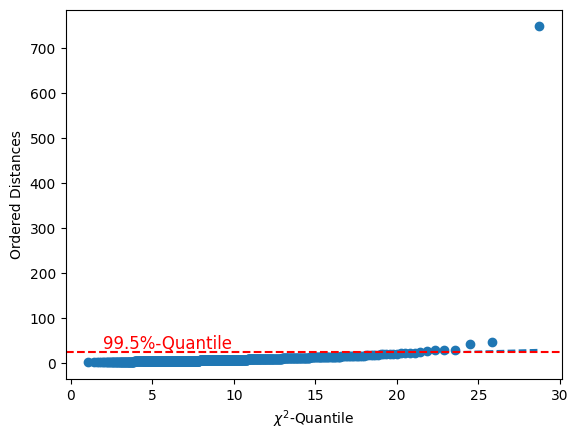

In [6]:
# plot theoretical and empirical quantiles
quantile_995 = chi2.ppf(1 - 0.005, df=deg_f)
plt.scatter(data['qc'], data['sorted_d'])
plt.plot(data['qc'], data['qc'], linestyle='--', label='y = x (slope 1)')
plt.xlabel(r'$\chi^2$-Quantile')
plt.ylabel('Ordered Distances')
plt.axhline(y=quantile_995, color='red', linestyle='--')
plt.text(2, quantile_995, '99.5%-Quantile', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

In [7]:
outlier = data[(data['sorted_d'] > 100)]
data = data[(data['sorted_d'] < 100)]

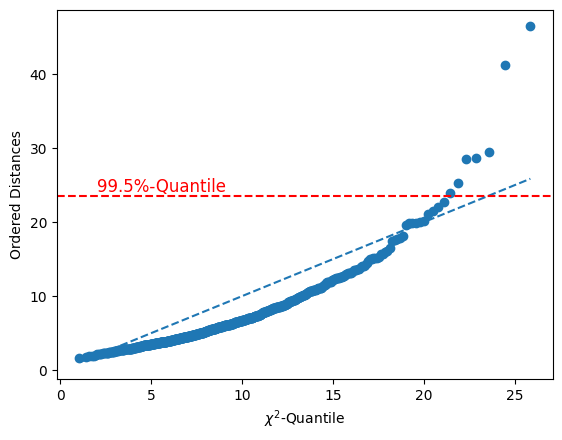

In [8]:
# plot theoretical and empirical quantiles
quantile_995 = chi2.ppf(1 - 0.005, df=deg_f)
plt.scatter(data['qc'], data['sorted_d'])
plt.plot(data['qc'], data['qc'], linestyle='--', label='y = x (slope 1)')
plt.xlabel(r'$\chi^2$-Quantile')
plt.ylabel('Ordered Distances')
plt.axhline(y=quantile_995, color='red', linestyle='--')
plt.text(2, quantile_995, '99.5%-Quantile', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

The data does not seem to follow a multivariate normal distribution. However, one observation still seems to differ a lot from all other observations.

In [9]:
# show the outstanding observation
outlier

,revenues,ebit,employees,market_cap,outstanding_shares,stock_price,industry_automobiles,industry_finance,industry_technology,sorted_d,qc
72,7.106195e+10,3.512886e+10,3510.179599,8.591727e+11,1.212385e+14,0.007164,False,False,True,747.786166,28.734312


This definitely seems to be an outlier. Even from a univariate perspective this seems to be an outlier in all features.

# Apply angle based approach to find multivariate outliers

In [10]:
# Depth-based clustering
def outliers_depth_based(x, k=1):
    x['idx'] = list(range(len(x)))
    x['outlier'] = [False for _ in range(len(x))]
    volumes = {}
    for i in range(k):
        # Filter the dataset to contain only observations not classified as outliers yet.
        x_filtered = x[~x['outlier']]
        if len(x_filtered) < 3:
            break
        x_chull = x_filtered.iloc[:, :-2]
        hull = ConvexHull(x_chull)
        volumes[i+1] = hull.volume
        idx = x_filtered.iloc[hull.vertices, -2]
        x.loc[idx, 'outlier'] = True
    return x[x['outlier']].index, volumes

In [11]:
df = one_hot_df.loc[:, ['revenues', 'ebit']]
idx, volumes = outliers_depth_based(x=df, k=1)
print(df)

         revenues          ebit  idx  outlier
0    9.894661e+10  3.368791e+10    0    False
1    8.989423e+10  5.421196e+10    1    False
2    8.783573e+10  4.223690e+10    2    False
3    7.903555e+10  2.921541e+10    3    False
4    7.531216e+10  3.333325e+10    4    False
..            ...           ...  ...      ...
745  4.367233e+10  2.770794e+10  745    False
746  5.439364e+10  3.002825e+10  746    False
747  5.089252e+10  3.439496e+10  747    False
748  4.411272e+10  2.596733e+10  748    False
749  4.319270e+10  2.467498e+10  749    False

[750 rows x 4 columns]


In [12]:
# prepare for plotting
df['outlier'] = [False for _ in range(len(df))]
df.loc[idx, 'outlier'] = True

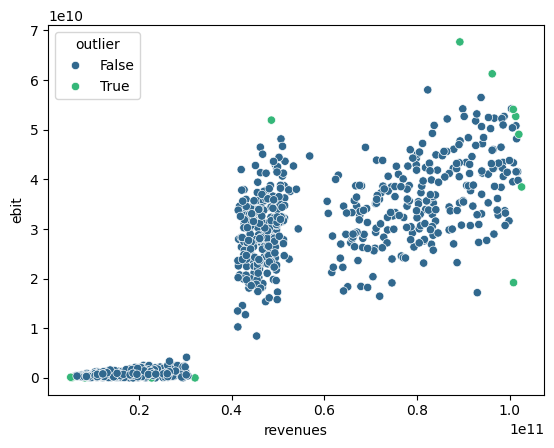

In [13]:
sns.scatterplot(data=df, x='revenues', y='ebit', hue='outlier', palette="viridis")
plt.xlabel('revenues')
plt.ylabel('ebit')
plt.show()

The lower cell has to be executed when the outliers are removed and the dataframe is ready

In [14]:
#merge with removed na-values
#final_df = pd.concat([df, missing_data], ignore_index=True)
#final_df.to_csv("data_2_no_outliers.csv")

We drop the outlier.

In [15]:
# Remove the outlier from the dataframe
outlier = base_df.iloc[72]
print(outlier)

# Remove the outlier from the dataframe
base_df = base_df.drop(index=72)
base_df

revenues                 71061950039.221527
ebit                     35128858294.228683
industry                         technology
employees                       3510.179599
market_cap              859172730171.426758
outstanding_shares    121238476777444.28125
stock_price                        0.007164
Name: 72, dtype: object


In [16]:
base_df.to_csv("data_2_no_outliers.csv")

In [17]:
base_df

,revenues,ebit,industry,employees,market_cap,outstanding_shares,stock_price
0,9.894661e+10,3.368791e+10,technology,39161.284575,8.610166e+11,8.920990e+09,98.094205
1,8.989423e+10,5.421196e+10,technology,NaN,1.169811e+12,1.817962e+10,64.925081
2,8.783573e+10,4.223690e+10,technology,86764.936060,7.737738e+11,6.672160e+09,120.558326
3,7.903555e+10,2.921541e+10,technology,157253.941191,6.624233e+11,4.560541e+09,148.060378
4,7.531216e+10,3.333325e+10,technology,85562.800295,6.352531e+11,1.253771e+10,50.603175
...,...,...,...,...,...,...,...
745,4.367233e+10,2.770794e+10,automobiles,25275.189008,5.527104e+11,2.663421e+10,21.238552
746,5.439364e+10,3.002825e+10,automobiles,126636.471476,2.344987e+11,1.828919e+09,127.065020
747,5.089252e+10,3.439496e+10,automobiles,160595.850319,8.319590e+11,1.913342e+10,44.512984
748,4.411272e+10,2.596733e+10,automobiles,16250.395261,2.355543e+11,2.298825e+09,102.313825
